### Load Data and Split

To Do List:

1. How well does the model generalize to other hero 20 runs?

2. Perform same transformations on the larger code set
3. Look into implementing the window functionality

Found 34 tensors with length 0 at indices: [810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 2460, 2501, 2512, 2583, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423]


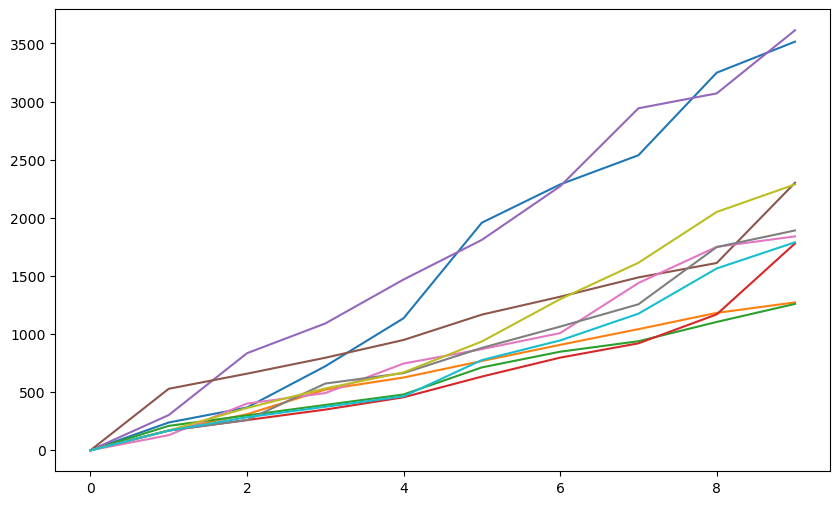

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

#from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%run data_prep_one_hero.ipynb

In [141]:
heroes.loc[heroes['id'] == 20, 'name']

19    npc_dota_hero_vengefulspirit
Name: name, dtype: object

Below we are selecting only one timeseries for the Hero_ID = 20, Vengeful Spirit. Later we will try to see how well the model performs on the other games of Vengeful Spirit.

We would like to test the model on new time-series.

In [142]:
def one_series_prep(df, index):

    one_series = pd.DataFrame(df.iloc[index]) # select chosen index
    one_series = one_series.reset_index(drop = False) # Create another index to serve as the minute column
    one_series = one_series.rename(columns={'index':'minute',0:'gold_t'}) # Re-name the column to be the minute column

    one_series = one_series[['gold_t']].values.astype('float32') # Convert gold_t values

    # Scaling the TimeSeries
    # if scale == True:
    #   scaler = MinMaxScaler()
    #   dataset_scaled = scaler.fit_transform(one_series) # Scaling the dataset
    # else: 
    #   dataset_scaled = one_series

    return one_series #, dataset_scaled



def train_split(series): 
    """ Split a series into training material and testing material
     
      Args:
        series: a time series from Pandas, pd.Series
    """
    train_size_dota = int(len(series) * 0.67) 
    test_size_dota = len(series) - train_size_dota
    train_dota, test_dota = series[:train_size_dota], series[train_size_dota:]

    return train_dota, test_dota 


In [143]:
df_20

0      [0, 239, 368, 723, 1136, 1958, 2287, 2538, 324...
1      [0, 170, 310, 522, 626, 768, 907, 1042, 1182, ...
2      [0, 210, 300, 390, 480, 713, 848, 938, 1104, 1...
3      [0, 170, 260, 350, 456, 634, 797, 920, 1169, 1...
4      [0, 303, 835, 1091, 1469, 1810, 2271, 2942, 30...
                             ...                        
301    [0, 170, 260, 395, 525, 662, 867, 1001, 1252, ...
302    [63, 272, 362, 452, 542, 891, 981, 1140, 1275,...
303    [0, 170, 260, 518, 608, 709, 799, 993, 1228, 1...
304    [0, 210, 351, 518, 668, 876, 1106, 1350, 1484,...
305    [0, 169, 259, 349, 563, 698, 834, 1059, 1305, ...
Name: gold_t, Length: 306, dtype: object

In [144]:
# Assuming your DataFrame is named 'df'
max_entries_index = df_20.apply(len).idxmax()
max_entries_count = df_20.iloc[max_entries_index]

print(f"The list with the most entries is at index {max_entries_index} with {max_entries_count} entries.")

The list with the most entries is at index 92 with [0, 169, 284, 374, 464, 601, 691, 781, 919, 1309, 1444, 1604, 1920, 2191, 2338, 2433, 2771, 3600, 3981, 4138, 4412, 4670, 4765, 4968, 5193, 5470, 5565, 5794, 5890, 6459, 6882, 7182, 7664, 7810, 8206, 8526, 8626, 9035, 9522, 10052, 10152, 10360, 10652, 10906, 11006, 11322, 11545, 11860, 11966, 12207, 12476, 13400, 13877, 13983, 14434, 14676, 14782, 15220, 15596, 15837, 16077, 16414, 16800, 17575, 17681, 17787, 17899, 18471, 18704, 18952, 19064, 19481, 20051, 21289, 21711, 22236, 22676, 24150, 24481, 24875, 25160, 25408, 25670, 26427, 26617, 27423, 28309, 28504] entries.


In [145]:
type(df_20[92])

list

In [146]:
df_allhero.iloc[32]['gold_t']

[0,
 214,
 500,
 906,
 1289,
 1632,
 1851,
 2111,
 2447,
 2732,
 3010,
 3453,
 3543,
 3638,
 3918,
 4594,
 5207,
 5587,
 5908,
 6286,
 6381,
 7099,
 7559,
 8062,
 8736,
 9064,
 9650,
 9945,
 10236,
 10862,
 11559,
 13968,
 14987,
 16100,
 17439,
 18101,
 18662,
 20374,
 20474,
 20966,
 22355,
 24163,
 24547,
 25724,
 27248,
 27458,
 29385,
 30331,
 31141,
 32101,
 32965,
 34140,
 34246]

Testing Function Logics:

In [147]:
def ConstantMinMaxScaler(series,min_gold,max_gold):
    
    dataset_scaled = (series - min_gold)/(max_gold - min_gold)
    return dataset_scaled

def ConstantUnScaler(series, min_gold, max_gold):
    
    dataset_unscaled = np.round((series * (max_gold - min_gold)) + min_gold)
    return dataset_unscaled


In [192]:
df_20[92]

one_series[['gold_t']].values.astype('float32')
#type(df_20[92])
#type(df_20)

array([[    0.],
       [  169.],
       [  284.],
       [  374.],
       [  464.],
       [  601.],
       [  691.],
       [  781.],
       [  919.],
       [ 1309.],
       [ 1444.],
       [ 1604.],
       [ 1920.],
       [ 2191.],
       [ 2338.],
       [ 2433.],
       [ 2771.],
       [ 3600.],
       [ 3981.],
       [ 4138.],
       [ 4412.],
       [ 4670.],
       [ 4765.],
       [ 4968.],
       [ 5193.],
       [ 5470.],
       [ 5565.],
       [ 5794.],
       [ 5890.],
       [ 6459.],
       [ 6882.],
       [ 7182.],
       [ 7664.],
       [ 7810.],
       [ 8206.],
       [ 8526.],
       [ 8626.],
       [ 9035.],
       [ 9522.],
       [10052.],
       [10152.],
       [10360.],
       [10652.],
       [10906.],
       [11006.],
       [11322.],
       [11545.],
       [11860.],
       [11966.],
       [12207.],
       [12476.],
       [13400.],
       [13877.],
       [13983.],
       [14434.],
       [14676.],
       [14782.],
       [15220.],
       [15596.

In [148]:
# We are performing the same operations to the scaled and unscaled data so that we can compare values between the two if it behooves us
one_series = pd.DataFrame(df_20[92]) # select chosen index
one_series = one_series.reset_index(drop = False) # Create another index to serve as the minute column
one_series = one_series.rename(columns={'index':'minute',0:'gold_t'}) # Re-name the column to be the minute column

dota_timeseries = one_series[['gold_t']].values.astype('float32') # Convert gold_t values

# Scaling the TimeSeries using global matches values
#dataset_scaled = (dota_timeseries - min_gold)/(max_gold - min_gold)

dataset_scaled = ConstantMinMaxScaler(dota_timeseries, min_gold, max_gold)


# Unscaled data
train_size_dota = int(len(dota_timeseries) * 0.67)
test_size_dota = len(dota_timeseries) - train_size_dota
train_dota, test_dota = dota_timeseries[:train_size_dota], dota_timeseries[train_size_dota:]

# Scaled data
train_size_scaled= int(len(dataset_scaled) * 0.67)
#test_size_scaled = len(dataset_scaled) - train_size_scaled
train_scaled, test_scaled = dataset_scaled[:train_size_scaled], dataset_scaled[train_size_scaled:]

In [179]:
#ConstantMinMaxScaler(one_series[['gold_t']].values, min_gold, max_gold)
type(one_series[['gold_t']])
#type(one_series[['gold_t']])
#type(dota_timeseries)
#type(dataset_scaled) numpy.ndarray

pandas.core.frame.DataFrame

In [150]:

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """

    # Scaled Return,
    X, y = [], []
    # Non-Scaled Return


    for i in range(len(dataset)-lookback): # The loop range subtracts lookback since a timeseries requires a number of windows to compute over
        # For example if we choose lookback = 4, meaning we look back over 4 time steps and predict on the 5th, if we have 30 timesteps, we can only create
        # the time series from the 5th timestep forward
        # Can think of the rest of these steps referencing a dataset of length 30 - 4 lookback steps = 26

        # No Scaling Window Creation
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
        print(type(X))
        
        
    # View List of Numpy Arrays
    #X_nots = X
    #y_nots = y

    X = torch.tensor(X)
    y = torch.tensor(y)

    

    return X, y #, X_nots, y_nots


In [151]:
# Testing iteration loop to see results
# for i in range(len(train_dota) - lookback):
#     print(i)
#     feature_nocs = train_dota[i:i+lookback] # i.e. 1 - 5, then 2 - 6
#     target_nocs = train_dota[i+1:i+lookback+1]
#     print(feature_nocs)
#     print(target_nocs)

In [152]:
# Testing Scaler Results

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# X_scaled = scaler.fit_transform(train_dota)

# X_scaled

Here we are using create_dataset to create our tensors of shape (window size, time steps, features).

Window Size: the full length of the time series
Time Steps: the number of steps the model can "lookback" on
Features: Number of features, ours will only be the time series

Note that we are returning the train and the test time series in the same size. This is because when we run the model on the test, it is going to use the same number of time steps (lookback = 4) to predict the next value, just like how the model trained.


A higher lookback window for dota caused a huge increase in accuracy with single digit RMSE's

### Creating the datasets

In [153]:
type(train_scaled)

numpy.ndarray

In [154]:
# Creating the datasets
lookback = 10

# Scaled
X_train_scaled, y_train_scaled = create_dataset(train_scaled, lookback=lookback)
X_test_scaled, y_test_scaled = create_dataset(test_scaled, lookback=lookback)

# Unscaled
X_train_dota, y_train_dota = create_dataset(train_dota, lookback=lookback)
X_test_dota, y_test_dota = create_dataset(test_dota, lookback=lookback)



<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'li

In [155]:
train_scaled.shape

(58, 1)

In [156]:
print(X_train_scaled.shape, y_train_scaled.shape)
print(X_test_scaled.shape, y_test_scaled.shape)

print(X_train_dota.shape, y_train_dota.shape)
print(X_test_dota.shape, y_test_dota.shape)

torch.Size([48, 10, 1]) torch.Size([48, 10, 1])
torch.Size([20, 10, 1]) torch.Size([20, 10, 1])
torch.Size([48, 10, 1]) torch.Size([48, 10, 1])
torch.Size([20, 10, 1]) torch.Size([20, 10, 1])


In [157]:
# Checking objects

#X_train_dota
#X_train_scaled

The output of nn.LSTM() is a tuple. The first element is the generated hidden states, one for each time step of the input. The second element is the LSTM cell’s memory and hidden states, which is not used here.

The LSTM layer is created with option batch_first=True because the tensors you prepared is in the dimension of (window sample, time steps, features) and where a batch is created by sampling on the first dimension. If batch_first=False, then the shape of the tensor changes. I believe the 2nd or the first changes.

### Creating LSTM Model

In [158]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [159]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = LSTMModel()
optimizer = optim.Adam(model.parameters() ,lr=0.001)
loss_fn = nn.MSELoss()
dota_loader = data.DataLoader(data.TensorDataset(X_train_scaled, y_train_scaled), shuffle=False, batch_size=8)

### Dota Training Loop

In [160]:
n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in dota_loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_scaled)
        train_rmse = np.sqrt(loss_fn(y_pred_train, y_train_scaled))
        y_pred_test = model(X_test_scaled)
        test_rmse = np.sqrt(loss_fn(y_pred_test, y_test_scaled))

        # Unscaled RMSE
        # Assuming you have the unscaled predicted values and actual values
        unscaled_y_pred_train = ConstantUnScaler(y_pred_train, min_gold, max_gold)
        y_train_unscaled = ConstantUnScaler(y_train_scaled, min_gold, max_gold)

        unscaled_train_rmse = np.sqrt(loss_fn(unscaled_y_pred_train, y_train_unscaled))  # unscaled actual values

        # Test Unscaled RMSE
        unscaled_y_pred_test =ConstantUnScaler(y_pred_test, min_gold, max_gold)
        y_test_unscaled = ConstantUnScaler(y_test_scaled, min_gold, max_gold)

        unscaled_test_rmse = np.sqrt(loss_fn(unscaled_y_pred_test, y_test_unscaled))


        #print("Root Mean Squared Error (RMSE):", train_rmse)
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f, unscaled train RMSE: %.4f, unscaled test RMSE: %.4f" % (epoch, train_rmse, test_rmse, unscaled_train_rmse,unscaled_test_rmse))

Epoch 0: train RMSE 0.0423, test RMSE 0.1584, unscaled train RMSE: 4409.3950, unscaled test RMSE: 16505.0664


Epoch 100: train RMSE 0.0107, test RMSE 0.0390, unscaled train RMSE: 1110.0177, unscaled test RMSE: 4065.4099
Epoch 200: train RMSE 0.0063, test RMSE 0.0227, unscaled train RMSE: 661.4639, unscaled test RMSE: 2367.1018
Epoch 300: train RMSE 0.0030, test RMSE 0.0096, unscaled train RMSE: 315.6635, unscaled test RMSE: 1001.2053
Epoch 400: train RMSE 0.0046, test RMSE 0.0059, unscaled train RMSE: 474.4399, unscaled test RMSE: 617.9620


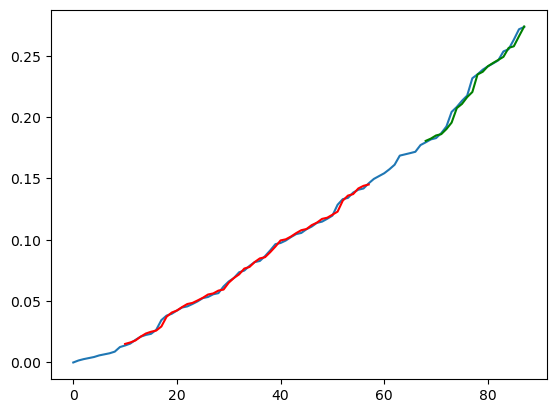

In [161]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(dataset_scaled) * np.nan # Creates an array with same length as dataset_scaled
    y_pred = model(X_train_scaled) # Creates predictions from the model using the X_train_scaled values
    y_pred = y_pred[:, -1, :] # Pulls those predictions
    train_plot[lookback:train_size_scaled] = model(X_train_scaled)[:, -1, :] # I believe that the model also outputs data in the tensor shape of (windows, time steps, features)
    # so when we pull model(X_train_scaled)[:, -1, :], we are pulling the last predictions
    
    # shift test predictions for plotting
    test_plot = np.ones_like(dataset_scaled) * np.nan
    test_plot[train_size_scaled+lookback:len(dataset_scaled)] = model(X_test_scaled)[:, -1, :]
# plot
plt.plot(dataset_scaled)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

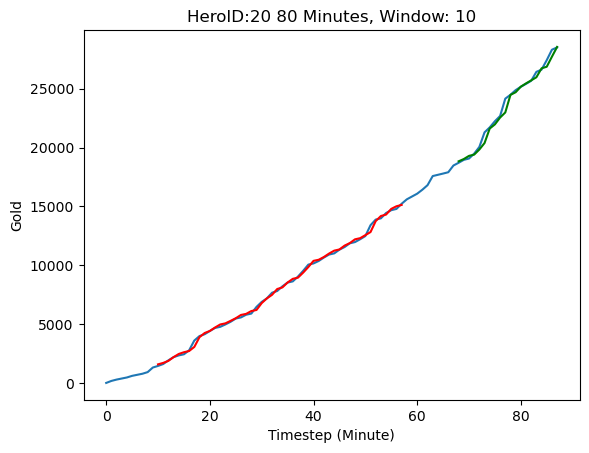

In [162]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(dataset_scaled) * np.nan # Creates an array with same length as dataset_scaled
    y_pred = model(X_train_scaled) # Creates predictions from the model using the X_train_scaled values
    y_pred = y_pred[:, -1, :] # Pulls those predictions
    y_pred_unscaled = ConstantUnScaler(y_pred, min_gold, max_gold) # Unscales preds
    train_plot[lookback:train_size_scaled] = ConstantUnScaler(model(X_train_scaled)[:, -1, :], min_gold,max_gold) # Unscaled train data 
    # so when we pull model(X_train_scaled)[:, -1, :], we are pulling the last values
    
    # shift test predictions for plotting
    test_plot = np.ones_like(dataset_scaled) * np.nan
    test_plot[train_size_scaled+lookback:len(dataset_scaled)] = ConstantUnScaler(model(X_test_scaled)[:, -1, :], min_gold,max_gold) # Unscaled test
# plot
plt.plot(dota_timeseries, label = "Actual Values")
plt.plot(train_plot, c='r', label = "Training Predictions")
plt.plot(test_plot, c='g', label = "Test Predictions")

plt.title('HeroID:20 80 Minutes, Window: 10')

# Add a label to the x-axis
plt.xlabel('Timestep (Minute)')

# Add a label to the y-axis
plt.ylabel('Gold')
plt.show()

### Generalization to Other Heroes



In [163]:
def generalize_metrics(df, max_scale_value, min_scale_value):

    

SyntaxError: incomplete input (927660759.py, line 3)

In [ ]:
print(lookback)

print(X_train_scaled.shape, y_train_scaled.shape)
print(X_test_scaled.shape, y_test_scaled.shape)

print(X_train_dota.shape, y_train_dota.shape)
print(X_test_dota.shape, y_test_dota.shape)

10

In [ ]:
def evaluate_model_on_series(index):
    # Prepare the new time series data
    new_series = pd.DataFrame(df_20[index])
    new_series = new_series.reset_index(drop=False)
    new_series = new_series.rename(columns={'index': 'minute', 0: 'gold_t'})
    new_timeseries = new_series[['gold_t']].values.astype('float32')
    
    # Scale the new time series using the same scaling method
    new_scaled_series = ConstantMinMaxScaler(new_timeseries,min_gold,max_gold)
    
    # Create the new dataset using the same lookback value
    new_X, new_y = create_dataset(new_scaled_series, lookback=lookback)
    
    # Use the trained model to make predictions on the new dataset
    with torch.no_grad():
        new_y_pred = model(new_X)
        
        # Unscale the predictions and actual values
        unscaled_new_y_pred = ConstantUnScaler(new_y_pred, min_gold,max_gold)
        unscaled_new_y = ConstantUnScaler(new_y, min_gold,max_gold)
        
        # Calculate RMSE for scaled data
        scaled_rmse = np.sqrt(loss_fn(new_y_pred, new_y))
        
        # Calculate RMSE for unscaled data
        unscaled_rmse = np.sqrt(loss_fn(unscaled_new_y_pred, unscaled_new_y))
        
    return scaled_rmse.item(), unscaled_rmse.item()

# Initialize empty lists to store the RMSE values
scaled_rmse_values = []
unscaled_rmse_values = []

# Loop over indexes in the range of 1 to 305
for index in range(1, 306):
    scaled_rmse, unscaled_rmse = evaluate_model_on_series(index)
    scaled_rmse_values.append(scaled_rmse)
    unscaled_rmse_values.append(unscaled_rmse)

# Create a DataFrame to store the RMSE values
rmse_df = pd.DataFrame({'Index': range(1, 306),
                        'Scaled RMSE': scaled_rmse_values,
                        'Unscaled RMSE': unscaled_rmse_values})

rmse_df = rmse_df.sort_values(by='Scaled RMSE', ascending=False)

In [ ]:
rmse_df

,Index,Scaled RMSE,Unscaled RMSE
265,266,0.004775,497.608368
216,217,0.004438,462.469788
62,63,0.004300,448.120758
79,80,0.004236,441.454895
11,12,0.004044,421.464142
...,...,...,...
131,132,0.001111,115.801071
201,202,0.001107,115.323570
275,276,0.001088,113.412689
285,286,0.001025,106.847893


The model seems to generalize well to all time series of Vengeful Spirit. The worst being the 92nd index of the 306 games with Venge. Let's take a look at that game in particular.

In [ ]:
df_no_zeros = df.drop(zero_length_indices)
df_20_match = df_no_zeros[df_no_zeros['hero_id'] == 20].reset_index(drop= True)
df_20_match.iloc[92]

match_id                                           7548252414
hero_id                                                    20
gold_t      [0, 169, 284, 374, 464, 601, 691, 781, 919, 13...
Name: 92, dtype: object

In [ ]:
df_20[92]

[0,
 169,
 284,
 374,
 464,
 601,
 691,
 781,
 919,
 1309,
 1444,
 1604,
 1920,
 2191,
 2338,
 2433,
 2771,
 3600,
 3981,
 4138,
 4412,
 4670,
 4765,
 4968,
 5193,
 5470,
 5565,
 5794,
 5890,
 6459,
 6882,
 7182,
 7664,
 7810,
 8206,
 8526,
 8626,
 9035,
 9522,
 10052,
 10152,
 10360,
 10652,
 10906,
 11006,
 11322,
 11545,
 11860,
 11966,
 12207,
 12476,
 13400,
 13877,
 13983,
 14434,
 14676,
 14782,
 15220,
 15596,
 15837,
 16077,
 16414,
 16800,
 17575,
 17681,
 17787,
 17899,
 18471,
 18704,
 18952,
 19064,
 19481,
 20051,
 21289,
 21711,
 22236,
 22676,
 24150,
 24481,
 24875,
 25160,
 25408,
 25670,
 26427,
 26617,
 27423,
 28309,
 28504]

To Do List:

1. How well does the model generalize to other heros?
- Create functions to loop over heros and provide their dataframes of timeseries, identify and train on the longest time series
- Create RMSE range metrics for each hero using the original forecasting
- Determine which heros are similar enough to Venge
- Determine how many more models to make


2. Generate graphs of time-series and their predictions to showcase accuracy

3. Work on sigmoid function to make predictions
- 10 hero categorical IDs, their forecasted gold for the next minute